<a href="https://colab.research.google.com/github/yashmehra028/so-fifa/blob/main/almost_final_so_fifa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup as bs
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
import pandas as pd
import re
from threading import Thread
import collections
import json
from datetime import datetime as dt

In [ ]:
def get_player_links(offset_value):
    player_links = []
    r = requests.get(f'https://sofifa.com/players?offset={offset_value}')
    all_players_page = bs(r.content)
    tables = all_players_page.select('td.col-name')
    for table in tables:
        a_tag = table.find('a')
        url = a_tag['href']
        if 'player' in url and 'players' not in url:
            player_links.append('https://sofifa.com' + url)

    counter = collections.Counter(player_links)
    return [i[0] for i in counter.most_common()]

In [ ]:
def real_func(n_pages):
    with concurrent.futures.ThreadPoolExecutor() as Executor:
        results = Executor.map(get_player_links,range(0,60*n_pages,60))
        result = []
        for i in results:  
            result += i

        a = collections.Counter(result)
        return [i[0] for i in a.most_common()]

In [287]:
def get_team(player_page):
    try:
        teams = [i.get_text() for i in player_page.select('h5 > a')]
        return [('Teams',teams)]

    except:
        return [('Marking',None)]

def get_name(player_page):

    try:
        name_div = player_page.find('div',attrs={'class':'info'})
        return [('Name',name_div.find('h1').get_text())]
    except:
        return [('Name',None)]

def get_section_box(player_page):
    try:
        info_list = []

        for initial_info in player_page.select('section'):
            text = initial_info.get_text()

        pattern = re.compile(r'[+-]\d{1,2}')
        if pattern.findall(text):
            for i in pattern.findall(text):
                text = text.replace(i,'').strip()

        
        pattern_num = re.compile(r'\d+[\.\d+]*[MK]*')
        pattern_text = re.compile(r'[A-Za-z]+')
        
        num_list = pattern_num.findall(text)
        char_list = pattern_text.findall(text)
        
        char_list[0] += ' ' + char_list[1]
        char_list.pop(1)
        a = len(num_list)
        for i in range(a):
            if 'M' in num_list[i]:
                num_list[i] = float(num_list[i].split('M')[0])*1000000
                char_list[i] = char_list[i].replace('M','')
            elif 'K' in num_list[i]:
                num_list[i] = float(num_list[i].split('K')[0])*1000
                char_list[i] = char_list[i].replace('K','')
            info_list.append((char_list[i],float(num_list[i])))
        return info_list
    except:
        return ['Marking', None]

def get_skills(player_page):

    try:
        valid_fields = ['Attacking', 'Skill', 'Movement','Power', 'Mentality', 'Defending', 'Goalkeeping']

        info_list = []
        divs = [i for i in player_page.select('div.card')]

        valid_divs = []
        for i in divs:
            if i.select('h5'):
                if i.select('h5')[0].get_text() in valid_fields:
                    valid_divs.append(i)

        
        for i in valid_divs:
            info = [j.get_text().strip() for j in i.select('li')]
            
            for j in info:
                pattern_num = re.compile(r'\d+')
                pattern_text = re.compile(r'[A-Za-z]+\s*[A-Za-z]*')

                try:
                    num = pattern_num.findall(j)[0]
                    char = pattern_text.findall(j)[0]
                    info_list.append((char,float(num)))
                    
                except:
                    pass


        return info_list
    
    except:
        return ['Marking',None]

def get_height_weight(player_page):

    
    try:
        all_text = player_page.find('div',attrs={'class':'meta ellipsis'}).get_text()
        position_patt = re.compile(r'[A-Z]{2,3}')
        positions = position_patt.findall(all_text)
        info_list = [('Positions',positions)]
        nationality = player_page.find('div',attrs={'class':'meta ellipsis'}).find('a')['title']
        info_list.append(('Nationality',nationality))

        body_measures = ['Age','Height','Weight']

        pattern = re.compile(r'\d+[c|k|y]')
        values = pattern.findall(all_text)

        for i in range(len(values)):
            info_list.append((body_measures[i],float(values[i][:len(values[i])-1])))

        return info_list
    except:
        return ['Marking', None]

def get_player_info(player_link):
    r = requests.get(player_link)
    player_page = bs(r.content)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        f1 = executor.submit(get_name,player_page)
        f2 = executor.submit(get_section_box,player_page)
        f3 = executor.submit(get_skills,player_page)
        f4 = executor.submit(get_height_weight,player_page)
        f5 = executor.submit(get_team,player_page)
        return f1.result() + f2.result() + f3.result() + f4.result() + f5.result() 

In [ ]:
def new_get_and_save_df(n_pages,name):

    links = real_func(n_pages)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(get_player_info,links)

        
        result = []
        a = 0
        for i in results:
            a += 1
            print(a,i)
            try:
                result.append(dict(i))
            except:
                pass


    df = pd.DataFrame(result)
    if 'Marking' in df.columns:
        df.drop('Marking',1,inplace=True)
    
    df.dropna(inplace=True)
    df.to_csv(f'{name}.csv')
    
    

    return df

df = new_get_and_save_df(300,'final_again_1')

In [304]:
df.shape

(17028, 45)

In [303]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17028 entries, 0 to 17893
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 17028 non-null  object 
 1   Overall Rating       17028 non-null  float64
 2   Potential            17028 non-null  float64
 3   Value                17028 non-null  float64
 4   Wage                 17028 non-null  float64
 5   Crossing             17028 non-null  float64
 6   Finishing            17028 non-null  float64
 7   Heading Accuracy     17028 non-null  float64
 8   Short Passing        17028 non-null  float64
 9   Volleys              17028 non-null  float64
 10  Dribbling            17028 non-null  float64
 11  Curve                17028 non-null  float64
 12  FK Accuracy          17028 non-null  float64
 13  Long Passing         17028 non-null  float64
 14  Ball Control         17028 non-null  float64
 15  Acceleration         17028 non-null 

chutiye itne desh hi nahi hai, 160 se kaam chalale



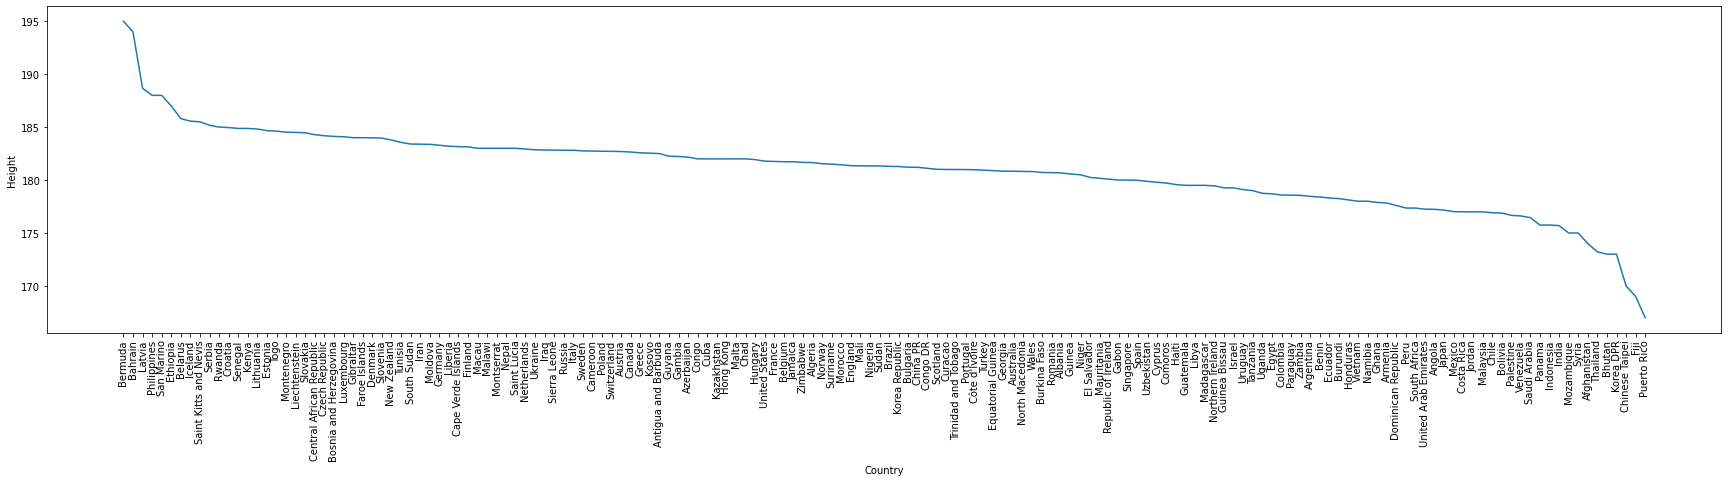

In [308]:
def plot_average_attr_country(df,n_top_countries,attribute):

    nations_group = df.groupby('Nationality')
    temp = [(nation,df1['Name'].count(),df1[attribute].sum()/df1[attribute].count()) for nation, df1 in nations_group]
    temp.sort(key=lambda x:x[1],reverse=True)
    
    if n_top_countries <= len(temp):
        temp2 = [(temp[i][0],temp[i][2]) for i in range(n_top_countries)]
        temp2.sort(key=lambda x:x[1],reverse=True) 
        top_countries = [temp2[i][0] for i in range(n_top_countries)]
        attr_value = [temp2[i][1] for i in range(n_top_countries)]
        plt.figure(figsize=(30,6))
        plt.xticks(rotation = 90)
        plt.plot(top_countries,attr_value)
        plt.xlabel(f'Country')
        plt.ylabel(f'{attribute}')
    
    else:
        print(f'chutiye itne desh hi nahi hai, {len(temp)} se kaam chalale\n')
        n_top_countries = len(temp)
        temp2 = [(temp[i][0],temp[i][2]) for i in range(n_top_countries)]
        temp2.sort(key=lambda x:x[1],reverse=True) 
        top_countries = [temp2[i][0] for i in range(n_top_countries)]
        attr_value = [temp2[i][1] for i in range(n_top_countries)]
        plt.figure(figsize=(30,6))
        plt.xticks(rotation = 90)
        plt.plot(top_countries,attr_value)
        plt.xlabel(f'Country')
        plt.ylabel(f'{attribute}')

plot_average_attr_country(df,200,'Height')